In [1]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_ollama import ChatOllama
import yfinance as yf


In [2]:
def multiply(a: int, b: int) -> int:
    """Multiply two integers.

    This tool takes two integers as input and returns their product. 
    Useful for calculating the result of multiplication operations.

    Args:
        a: The first integer to multiply.
        b: The second integer to multiply.
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add two integers.

    This tool takes two integers as input and returns their sum. 
    Useful for combining values or performing addition operations.

    Args:
        a: The first integer to add.
        b: The second integer to add.
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide one integer by another.

    This tool divides the first integer by the second and returns the quotient as a float. 
    Use this for division operations where the result may be fractional.

    Args:
        a: The numerator.
        b: The denominator (must not be zero).
    """
    return a / b


def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

tools = [add, multiply, divide, search, get_stock_price]

In [20]:
# llm = ChatOllama(model="qwen2.5:14b", temperature=0.3)
# llm = ChatOllama(model="llama3.2:latest", temperature=0.3)
llm = ChatOllama(model="mistral-nemo", temperature=0.1)
# System message
sys_msg = SystemMessage(content="You are a financial and mathematical assistant specializing in solving complex numerical problems, performing precise calculations, and interpreting financial data. Your role is to provide accurate results, explain steps clearly, and ensure all responses are logically sound and contextually relevant to the given task.")

llm_with_tools = llm.bind_tools(tools)

In [21]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

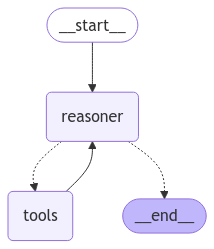

In [26]:
# Node
def reasoner(state: MessagesState):
   aws = llm_with_tools.invoke([sys_msg] + state["messages"])
   return {"messages": aws}

# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "reasoner")
app = builder.compile()

app

In [23]:
messages = [HumanMessage(content="What is 2 times one hundred?")]
messages = app.invoke({"messages": messages})

Reasoner: [SystemMessage(content='You are a financial and mathematical assistant specializing in solving complex numerical problems, performing precise calculations, and interpreting financial data. Your role is to provide accurate results, explain steps clearly, and ensure all responses are logically sound and contextually relevant to the given task.', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is 2 times one hundred?', additional_kwargs={}, response_metadata={}, id='75f7d450-857f-47da-8522-7fdb0c26c39a')]
--------------------
AWS: content='' additional_kwargs={} response_metadata={'model': 'mistral-nemo', 'created_at': '2025-01-17T17:00:19.982895Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2775176167, 'load_duration': 34164167, 'prompt_eval_count': 482, 'prompt_eval_duration': 1442000000, 'eval_count': 28, 'eval_duration': 1291000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-a73f33c0-68ea-4f79-8

In [25]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times one hundred?
================================== Ai Message ==================================
Tool Calls:
  multiply (2264c594-193e-43e4-a887-b05887880a18)
 Call ID: 2264c594-193e-43e4-a887-b05887880a18
  Args:
    a: 2
    b: 100
================================= Tool Message =================================
Name: multiply

200
================================== Ai Message ==================================

Two times one hundred equals two hundred. (2 × 100 = 200)


In [27]:
inputs = {"messages": [{"role": "user", "content": "What is the stock price of the company that Jensen Huang is CEO of?"}]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (e3094d9c-8351-4b42-9f38-d0a9affcf18b)
 Call ID: e3094d9c-8351-4b42-9f38-d0a9affcf18b
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

133.57
================================== Ai Message ==================================

The current stock price of NVIDIA Corporation, where Jensen Huang serves as President and Chief Executive Officer, is $133.57.


# Change resoner template

In [76]:
llm = ChatOllama(model="qwen2.5:14b", temperature=0.1)
# llm = ChatOllama(model="llama3.2:latest", temperature=0.3)
# llm = ChatOllama(model="mistral-nemo", temperature=0.1)
# System message
sys_msg = SystemMessage(content="You are a financial and mathematical assistant specializing in solving complex numerical problems, performing precise calculations, and interpreting financial data. Your role is to provide accurate results, explain steps clearly, and ensure all responses are logically sound and contextually relevant to the given task.")

llm_with_tools = llm.bind_tools(tools)

In [77]:
class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    human = HumanMessage(content=query)
    result = [llm_with_tools.invoke([sys_msg,human] + messages)]
    return {"messages":result}

In [78]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
# display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [69]:
response = react_graph.invoke({"query": "What is 2 times Brad Pitt's age?", "messages": []})

In [45]:
# mistral-nemo
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (47717754-de96-48f0-b29c-72308c2e1143)
 Call ID: 47717754-de96-48f0-b29c-72308c2e1143
  Args:
    query: Brad pitt age
================================= Tool Message =================================
Name: duckduckgo_search

Actor Brad Pitt is known the movies 'Fight Club,' 'The Curious Case of Benjamin Button,' and 'Moneyball.' Read about his age, girlfriend, children, and more. Brad Pitt is an American actor known for his portrayal of unconventional characters. He channeled his magnetism as a leading man in Legends of the Fall (1994) but avoided being typecast by playing offbeat characters. ... December 18, 1963, Shawnee, Oklahoma, U.S. (age 61) (Show more) Founder: Make It Right Not on Our Watch (Show more) Awards ... Brad Pitt's latest birthday marks the third he is celebrating since starting to date girlfriend Inés de Ramón. The F1 actor celebrated his 61st birthday thi

In [59]:
# qwen2.5:14b
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (59b6c788-9a3a-4585-bf57-c4889101f3cc)
 Call ID: 59b6c788-9a3a-4585-bf57-c4889101f3cc
  Args:
    query: Brad Pitt age
================================= Tool Message =================================
Name: duckduckgo_search

Actor Brad Pitt is known the movies 'Fight Club,' 'The Curious Case of Benjamin Button,' and 'Moneyball.' Read about his age, girlfriend, children, and more. Brad Pitt is an American actor known for his portrayal of unconventional characters. He channeled his magnetism as a leading man in Legends of the Fall (1994) but avoided being typecast by playing offbeat characters. ... December 18, 1963, Shawnee, Oklahoma, U.S. (age 61) (Show more) Founder: Make It Right Not on Our Watch (Show more) Awards ... Brad Pitt's latest birthday marks the third he is celebrating since starting to date girlfriend Inés de Ramón. The F1 actor celebrated his 61st birthday thi

In [60]:
response = react_graph.invoke({"query": "What is the stock price of the company that Jensen Huang is CEO of?", "messages": []})

In [21]:
# mistral-nemo
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (2ad5f2b5-f631-4ee4-886f-974eac3b95ba)
 Call ID: 2ad5f2b5-f631-4ee4-886f-974eac3b95ba
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

133.23
================================ Human Message =================================

What is the stock price of the company that Jensen Huang is CEO of?
================================== Ai Message ==================================

The stock price of the company that Jensen Huang is the CEO of (NVIDIA, represented by the ticker NVDA) is $133.23.


In [61]:
# qwem2.5:14b
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_stock_price (d88cc28d-eea9-4ea9-8374-3215606f2a35)
 Call ID: d88cc28d-eea9-4ea9-8374-3215606f2a35
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: get_stock_price

133.57
================================== Ai Message ==================================

The current stock price of NVIDIA Corporation, where Jensen Huang is the CEO, is $133.57.


In [79]:
response = react_graph.invoke({"query": "What is the percent of profit if I bought NVIDIA stock from IPO to today?", "messages": []})

In [75]:
# mistral-nemo
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_stock_price (25f23b43-6786-47f1-aae0-c8aeebe3e70c)
 Call ID: 25f23b43-6786-47f1-aae0-c8aeebe3e70c
  Args:
    ticker: NVDA
  duckduckgo_search (02b942b6-64ea-4a95-999e-4869864aa701)
 Call ID: 02b942b6-64ea-4a95-999e-4869864aa701
  Args:
    query: NVIDIA IPO price
================================= Tool Message =================================
Name: get_stock_price

133.57
================================= Tool Message =================================
Name: duckduckgo_search

Current Price. $136.24. Price as of January 15, 2025, 4:00 p.m. ET. ... If you'd picked up one share of Nvidia at its IPO in January 1999, that single share would have ballooned to 480 shares ... If you bought one share at the company's IPO, you'd have 480 shares now. At today's prices, 480 shares of Nvidia stock are worth $66,371. However, the company also pays a dividend. Since its IPO in January 1999, Nvidia ... 

In [80]:
# qwem2.5:14b
for m in response['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (e27d43ba-58c6-4a6f-ada1-851bbe941359)
 Call ID: e27d43ba-58c6-4a6f-ada1-851bbe941359
  Args:
    query: NVIDIA stock IPO date and opening price
  get_stock_price (bc1f3083-3762-49b5-9d19-06b3d4e334fd)
 Call ID: bc1f3083-3762-49b5-9d19-06b3d4e334fd
  Args:
    ticker: NVDA
================================= Tool Message =================================
Name: duckduckgo_search

Nvidia (NVDA 3.40%) is one artificial intelligence (AI) stock you probably wish you'd scooped up at its initial public offering (IPO). The chipmaker debuted on Jan. 22, 1999 at just $12 per share. All told, an investor who bought 100 shares of NVDA stock in the 1999 IPO would now own 48,000 shares of Nvidia thanks to all the share splits along the way. Shares started trading at around 4 ... Today, the original $1,000 investment in Nvidia stock would be worth $3,575,696.97 based on a share price of $893

# stream

In [52]:
inputs = {"query": "What is 2 + 34?", "messages": []}
first = True
for chunk in react_graph.stream(inputs, stream_mode="values"):
    if first:
        print(chunk["query"])
        first = False
    else:
        print(chunk["messages"][-1])

What is 2 + 34?
[]
content='' additional_kwargs={} response_metadata={'model': 'mistral-nemo', 'created_at': '2025-01-17T17:20:16.975231Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5158115250, 'load_duration': 40232458, 'prompt_eval_count': 455, 'prompt_eval_duration': 3906000000, 'eval_count': 26, 'eval_duration': 1206000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-0f616649-9a96-48a7-b0f7-612fa2684a4c-0' tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 34}, 'id': '9d71d09d-1368-433a-ad9b-5f8f29caa379', 'type': 'tool_call'}] usage_metadata={'input_tokens': 455, 'output_tokens': 26, 'total_tokens': 481}
content='36' name='add' tool_call_id='9d71d09d-1368-433a-ad9b-5f8f29caa379'
[AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'mistral-nemo', 'created_at': '2025-01-17T17:20:16.975231Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5158115250, 'load_duration': 40232458, 'prompt_eval_count': 45

# Logging

In [40]:
llm = ChatOllama(model="mistral-nemo", temperature=0.3)
llm_with_tools = llm.bind_tools(tools)
aws = llm_with_tools.invoke([sys_msg] + messages)
aws.tool_calls

TypeError: unsupported operand type(s) for |: 'list' and 'AddableValuesDict'

In [41]:
sys_msg

SystemMessage(content='You are a financial and mathematical assistant specializing in solving complex numerical problems, performing precise calculations, and interpreting financial data. Your role is to provide accurate results, explain steps clearly, and ensure all responses are logically sound and contextually relevant to the given task.', additional_kwargs={}, response_metadata={})

# Check tools

In [52]:
import inspect

signature = inspect.signature(multiply)
docstring = multiply.__doc__ or ""
signature,docstring

(<Signature (a: int, b: int) -> int>,
 'Multiply two integers.\n\n    This tool takes two integers as input and returns their product. \n    Useful for calculating the result of multiplication operations.\n\n    Args:\n        a: The first integer to multiply.\n        b: The second integer to multiply.\n    ')

In [53]:
params = [
    {"name": param.name, "type": param.annotation}
    for param in signature.parameters.values()
]
params

[{'name': 'a', 'type': int}, {'name': 'b', 'type': int}]

In [54]:
tool_info = {
    "name": multiply.__name__,
    "description": docstring,
    "parameters": params
}
tool_info

{'name': 'multiply',
 'description': 'Multiply two integers.\n\n    This tool takes two integers as input and returns their product. \n    Useful for calculating the result of multiplication operations.\n\n    Args:\n        a: The first integer to multiply.\n        b: The second integer to multiply.\n    ',
 'parameters': [{'name': 'a', 'type': int}, {'name': 'b', 'type': int}]}